# Ridge Regression, Prostate cancer
Irving Gomez Mendez

February 27, 2021

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_csv("prostate_dataset.txt", sep='\t')
data = data.drop(['col'], axis=1)

data

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...
92,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [3]:
# The data were collected on n=97 men before radical prostatectomy,
# which a major surgical operation that removes the entire prostate
# gland along with some surrounding tissue.

# lcavol  = log cancer volumne, measure in milliliters (cc). The area
#           of cancer was measure from digitized images and multiplied
#           by a thickness to produce a volume.
# lweight = log prostate weight
# age     = age
# lbph    = log of the amount of benign prostatic hyperplasia, a
#           noncancerous enlargement of the prostate gland, as an area in
#           a digitized image and reported in cm2.
# svi     = seminal vesicle invasion, a 0/1 indicator of whether prostate
#           cancer cells hae invaded the vesicle.
# lcp     = log capsular penetration, which represents the level of
#           extension of cancer into the capsule (the fibrous tissue
#           which acts as an outer lining of the prostate gland).
#           Measure as the linear extent of penetration, in cm.
# gleason = Gleason score, a measure of the degree of aggressiveness of
#           the tumor. The Gleason grading system assigns a grade
#           to each of the two largest areas of cancer in the tissue
#           samples with 1 being the least aggressive and 5 the most
#           aggressive; the two grades are then added together to produce
#           the Gleason score.
# pgg45   = percent of Gleason score 4 or 5.
# lpsa    = log prostate specific antigen

# See Hastie et al (2008) The Elements of Stat. Learning (pp. 49)
# and Wakefiled (2013) (pp. 5)

# PSA is a concentration and is measure in ng/ml.
# In Stamey et al (1989), PSA was proposed as a preoperative marker
# to predict  the clinical stage of cancer.
# PSA is a protein produced by the cells of the prostate gland.
# PSA is present in small quantities in the serum of men with healthy
# prostates, but is often elevated in the presence of prostate cancer
# and in other prostate disorders. A blood test to measure PSA is
# considered the most effective test currently available for the early
# detection of prostate cancer, but this effectiveness has also
# been questioned. Rising levels of PSA over time are associated
# with both localized and metastatic prostate cancer.

### Creating the training and testing data sets

In [4]:
train_data = data[data['train'] == 'T']
test_data = data[data['train'] == 'F']

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

data = data.drop(['train'], axis=1)
train_data = train_data.drop(['train'], axis=1)
test_data = test_data.drop(['train'], axis=1)

scaler = StandardScaler().fit(train_data)
train_data = pd.DataFrame(scaler.transform(train_data), columns = train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns = test_data.columns)

X_train = train_data.drop('lpsa', axis=1)
y_train = train_data['lpsa']

X_test = test_data.drop('lpsa', axis=1)
y_test = test_data['lpsa']

n_train, p = X_train.shape
n_test, p = X_test.shape

X_train.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
count,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01
mean,4.971148e-17,9.378899e-16,-8.343243e-16,6.628197e-18,3.976918e-17,-4.308328e-17,4.921436e-16,-3.314099e-17
std,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00
min,-2.157304e+00,-2.645075e+00,-3.189126e+00,-1.003472e+00,-5.370862e-01,-8.430840e-01,-1.039499e+00,-9.032532e-01
25%,-6.691190e-01,-6.252199e-01,-5.031242e-01,-1.003472e+00,-5.370862e-01,-8.430840e-01,-1.039499e+00,-9.032532e-01
50%,1.251804e-01,-5.798078e-02,3.407614e-02,-8.448679e-02,-5.370862e-01,-4.202897e-01,3.818568e-01,-3.874751e-01
75%,8.396889e-01,5.443671e-01,5.712765e-01,1.016091e+00,-5.370862e-01,8.696292e-01,3.818568e-01,8.160072e-01
max,2.033202e+00,2.440170e+00,1.914277e+00,1.552196e+00,1.861899e+00,2.065078e+00,3.224568e+00,2.535268e+00


In [7]:
1/n_train*(X_train.T @ X_train)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


### Exploring multicolinearity

In [5]:
np.linalg.cond(X_train)

4.4356083801314865

<AxesSubplot:>

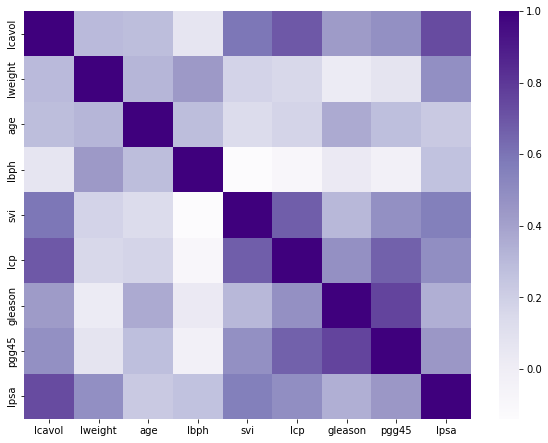

In [6]:
corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
plt.figure(figsize=(10,7.5))
sns.heatmap(corr_matrix, cmap='Purples')

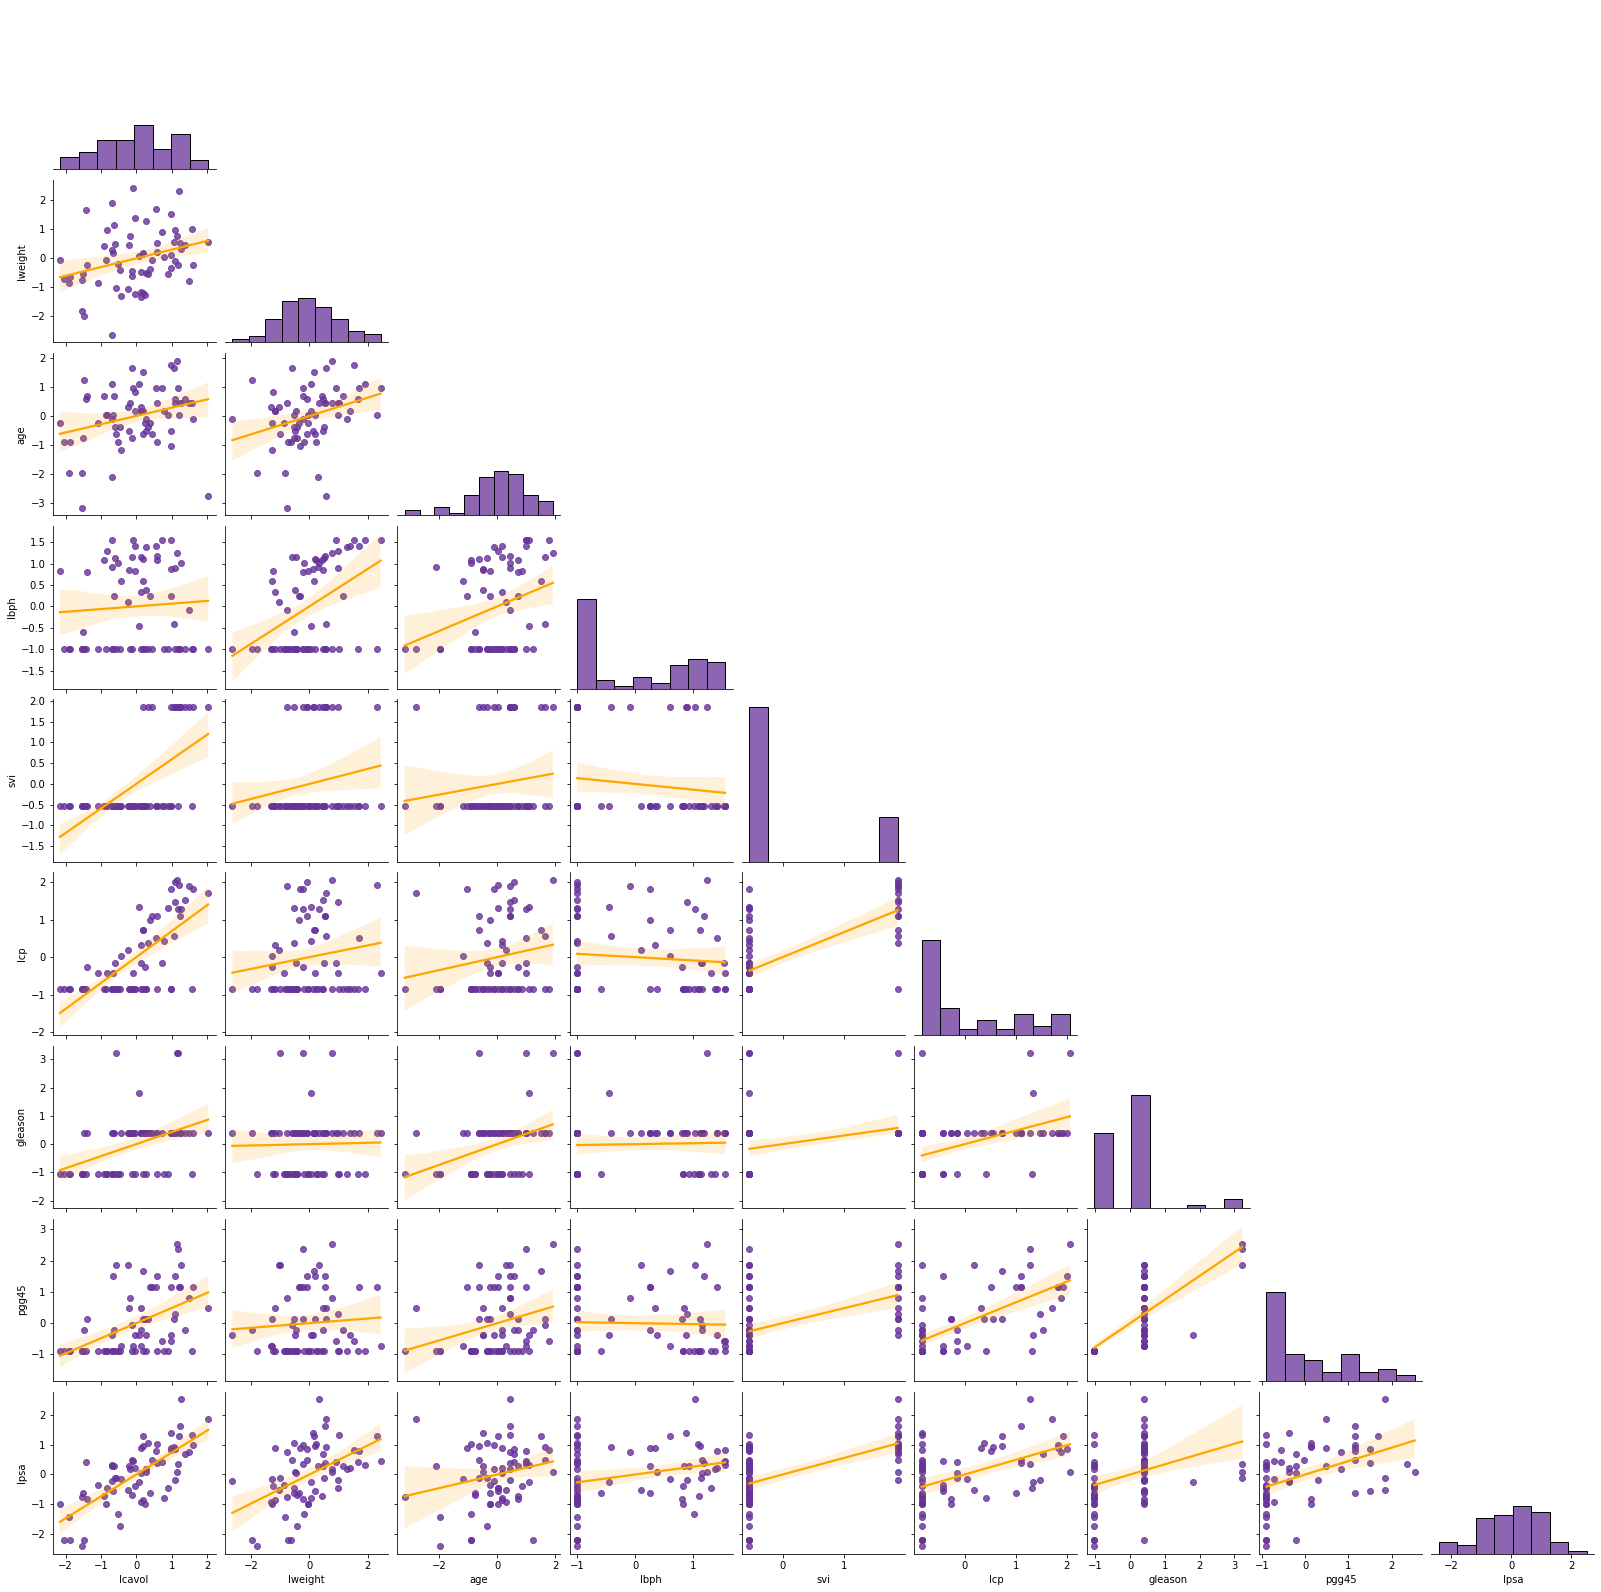

In [7]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), kind="reg", corner = True,
    plot_kws={'line_kws':{'color':'orange'}, 'scatter_kws': {'color': 'rebeccapurple'}},
    diag_kws={'color': 'rebeccapurple'})

In [8]:
# Variance Inlfation Factors
# VIFS bigger than 5 might suggest collinearity
vif = pd.DataFrame()
vif["VIF_Factor"] = np.round([variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],2)
vif["features"] = X_train.columns
vif

,VIF_Factor,features
0,2.32,lcavol
1,1.47,lweight
2,1.36,age
3,1.38,lbph
4,2.05,svi
5,3.12,lcp
6,2.64,gleason
7,3.31,pgg45


In [9]:
# SVD
u, d, vt = np.linalg.svd(X_train)
v = vt.T

# Singular Values
d

array([15.15186295, 10.45809199,  8.33410584,  6.43638252,  5.52262052,
        5.02380897,  4.3310785 ,  3.41596048])

In [10]:
# Condition Indexes
d[0]/d

array([1.        , 1.44881714, 1.81805502, 2.35409609, 2.74360023,
       3.01601097, 3.49840414, 4.43560838])

In [11]:
#There is no evidence of collinearity

# Variance-Decomposition Proportions
phis = v**2/d**2
var_decomp_proportions = phis.T/sum(phis.T)

In [12]:
pd.DataFrame(var_decomp_proportions).style.format(precision=2).background_gradient(cmap='Purples', vmin=0, vmax=1)

,0,1,2,3,4,5,6,7
0,0.02,0.01,0.01,0.00,0.02,0.02,0.02,0.02
1,0.00,0.13,0.08,0.19,0.01,0.01,0.00,0.00
2,0.03,0.10,0.10,0.00,0.08,0.01,0.11,0.03
3,0.00,0.00,0.68,0.34,0.02,0.01,0.02,0.03
4,0.15,0.71,0.04,0.34,0.01,0.01,0.03,0.05
5,0.46,0.03,0.03,0.13,0.59,0.00,0.02,0.02
6,0.12,0.00,0.07,0.00,0.28,0.54,0.28,0.06
7,0.20,0.01,0.00,0.00,0.00,0.41,0.52,0.78


<AxesSubplot:>

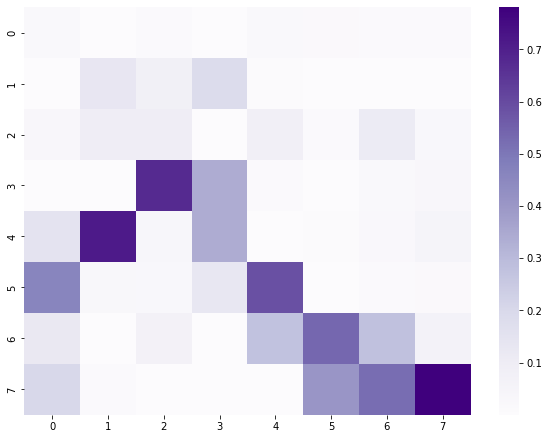

In [13]:
plt.figure(figsize=(10,7.5))
sns.heatmap(var_decomp_proportions, cmap='Purples')

In [14]:
## Regresion Ridge
results = sm.OLS(y_train,X_train).fit()
s2 = results.scale
params = results.params

lambda_0 = p*s2/(params.T @ params)
lambda_0

4.398419453190212

In [15]:
n_lambdas = 200
lambdas = np.logspace(-2, 5, n_lambdas)

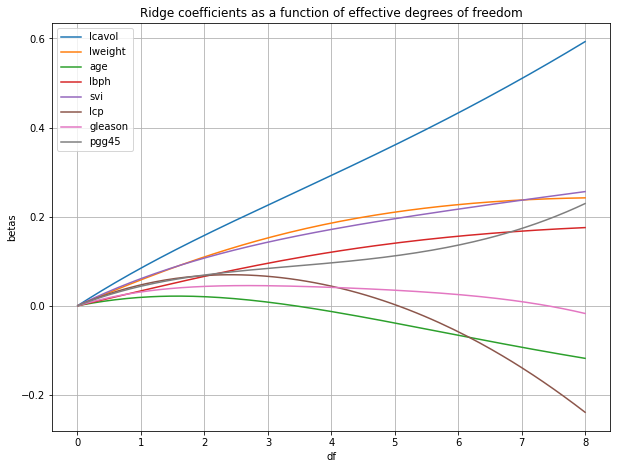

In [16]:
df_l = []
coefs = []

for l in lambdas:
    df_l.append(sum(d**2/(d**2+l)))
    ridge = Ridge(alpha=l, fit_intercept=True).fit(X_train, y_train)
    coefs.append(ridge.coef_)

fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(df_l, coefs)
ax.set_xlabel('df')
ax.set_ylabel('betas')
ax.set_title('Ridge coefficients as a function of effective degrees of freedom')
ax.grid(True)
plt.legend(X_train.columns)

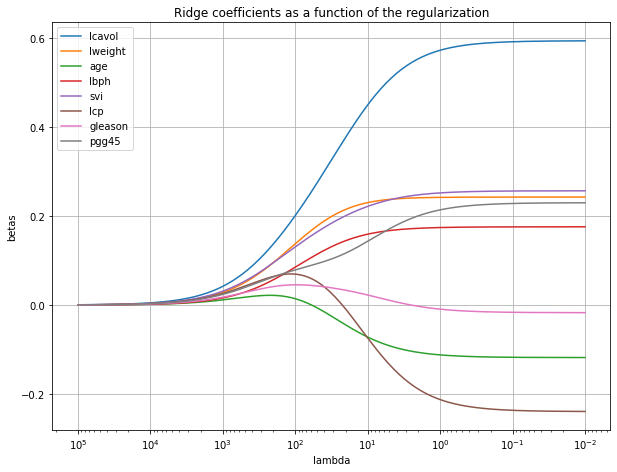

In [17]:
fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # decreasing time
ax.set_xlabel('lambda')
ax.set_ylabel('betas')
ax.set_title('Ridge coefficients as a function of the regularization')
ax.grid(True)
plt.legend(X_train.columns)

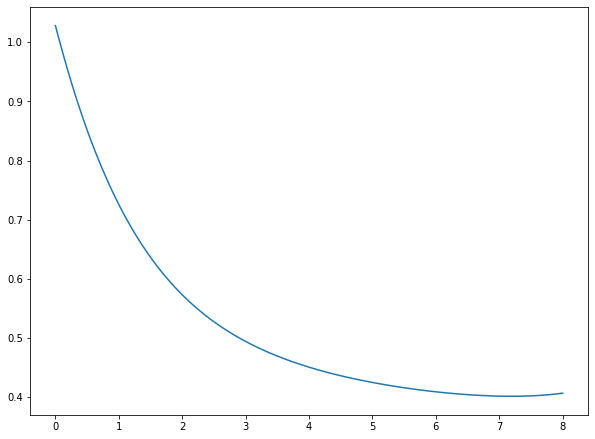

In [18]:
n_repeats = 1
n_splits = 67
kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

MSE_per_lambda_and_K_fold = np.zeros((n_repeats*n_splits, n_lambdas))

for i, index in enumerate(kf.split(X_train)):
    train_index, valid_index = index
    X_Kfold, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_Kfold, y_valid = y_train[train_index], y_train[valid_index]

    for j, l in enumerate(lambdas):
        ridge = Ridge(alpha=l).fit(X_Kfold, y_Kfold)
        hat_y_valid = ridge.predict(X_valid)
        MSE_per_lambda_and_K_fold[i,j] = mean_squared_error(y_valid, hat_y_valid)

mean_MSE = MSE_per_lambda_and_K_fold.mean(axis=0)

plt.figure(figsize=(10,7.5))
plt.plot(df_l, mean_MSE)

In [19]:
hat_lambda = lambdas[np.argmin(mean_MSE)]
hat_lambda
sum(d**2/(d**2+hat_lambda))
mean_MSE.min()

0.40112820575752944

In [20]:
model_ridge = Ridge(alpha=hat_lambda).fit(X_train,y_train)
model_ridge.coef_

-1.5994664197436283e-16

In [ ]:
model_ridge.intercept_

In [21]:
clf = RidgeCV(alphas=lambdas).fit(X_train, y_train)
clf.alpha_

In [ ]:
clf.best_score_

In [ ]:
clf.coef_

In [ ]:
clf.intercept_

In [ ]:
aux = np.linalg.inv(X_train.T @ X_train + clf.alpha_ * np.eye(p))
ridge_vifs = np.diag(aux @ X_train.T @ X_train @ aux)

In [22]:
n_train * ridge_vifs

array([0.02528208, 0.01804741, 0.01706674, 0.01721114, 0.02328154,
       0.03070513, 0.02640221, 0.03095129])

In [5]:
vif

NameError: name 'vif' is not defined

In [10]:
n_train * np.diag(np.linalg.inv(X_train.T @ X_train))

array([2.31849589, 1.47229503, 1.35660366, 1.38342908, 2.04531301,
       3.11745072, 2.64448034, 3.31328848])

In [24]:
mean_squared_error(y_test, clf.predict(X_test))

0.346628240673074

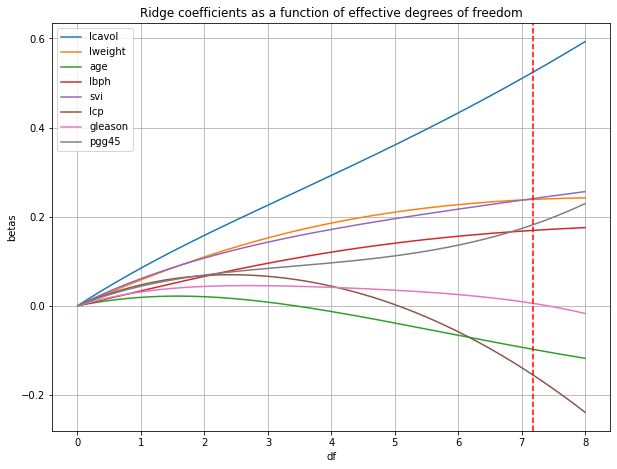

In [25]:
fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(df_l, coefs)
ax.set_xlabel('df')
ax.set_ylabel('betas')
ax.set_title('Ridge coefficients as a function of effective degrees of freedom')
ax.grid(True)
plt.axvline(sum(d**2/(d**2+clf.alpha_)), c='r', ls='--')
plt.legend(X_train.columns)

plt.savefig('Traza_Ridge.png')

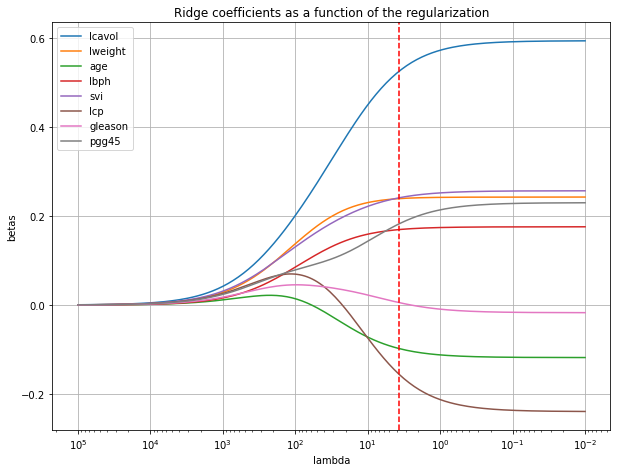

In [26]:
fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # decreasing time
ax.set_xlabel('lambda')
ax.set_ylabel('betas')
ax.set_title('Ridge coefficients as a function of the regularization')
ax.grid(True)
plt.axvline(clf.alpha_, c='r', ls='--')
plt.legend(X_train.columns)